In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint

from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
city_root = "../../data/cowc_cities"

cities = os.listdir(city_root)
print(cities)    

['Columbus_CSUAV_AFRL.txt', 'Potsdam_ISPRS.txt', 'Selwyn_LINZ.txt', 'Toronto_ISPRS.txt', 'Utah_AGRC.txt', 'Vaihingen_ISPRS.txt']


In [3]:
def extract_scene_stats(scene, px2kilometer=0.15 * 0.001):
    
    annotation = Image.open(scene)
    annotation = np.array(annotation)
    
    h, w, _ = annotation.shape
    
    area_km2 = (h * px2kilometer) * (w * px2kilometer)
    
    cars = (annotation[:, :, 0] > 0).sum()
    
    return {'area [km^2]': area_km2, 'cars': cars}


def extract_city_stats(scenes):
    
    area_km2 = 0.0
    cars = 0
    
    for scene in scenes:
        scene_stats = extract_scene_stats(scene)
        
        area_km2 += scene_stats['area [km^2]']
        cars += scene_stats['cars']
    
    return {'area [km^2]': area_km2, 'cars': cars}

In [4]:
data_root = "../../data/cowc/datasets/ground_truth_sets"

stats = {}

for city in cities:
    
    city_name, _ = os.path.splitext(city)
    
    with open(os.path.join(city_root, city)) as f:
        scenes = f.readlines()
    
    annotated_scenes = []
    
    for scene in scenes:
        scene = scene.rstrip()
        
        annotation_file = scene + "_Annotated_Cars.png"
        annotation_path = os.path.join(data_root, os.path.join(city_name, annotation_file))
        
        annotated_scenes.append(annotation_path)
    
    print("Loading {} ...".format(city_name))
    city_stats = extract_city_stats(annotated_scenes)
    
    stats[city_name] = city_stats

print("Done!")

Loading Columbus_CSUAV_AFRL ...
Loading Potsdam_ISPRS ...
Loading Selwyn_LINZ ...
Loading Toronto_ISPRS ...
Loading Utah_AGRC ...
Loading Vaihingen_ISPRS ...
Done!


In [5]:
stats_df = pd.DataFrame.from_dict(stats, orient='index')

stats_df['cars [/km^2]'] = stats_df['cars'] / stats_df['area [km^2]']

stats_df

,area [km^2],cars,cars [/km^2]
Columbus_CSUAV_AFRL,1.110311,1748,1574.334333
Potsdam_ISPRS,1.441557,2083,1444.965409
Selwyn_LINZ,20.285221,1197,59.008477
Toronto_ISPRS,5.821875,10023,1721.610306
Utah_AGRC,19.887949,19807,995.929770
Vaihingen_ISPRS,3.493732,2863,819.467432


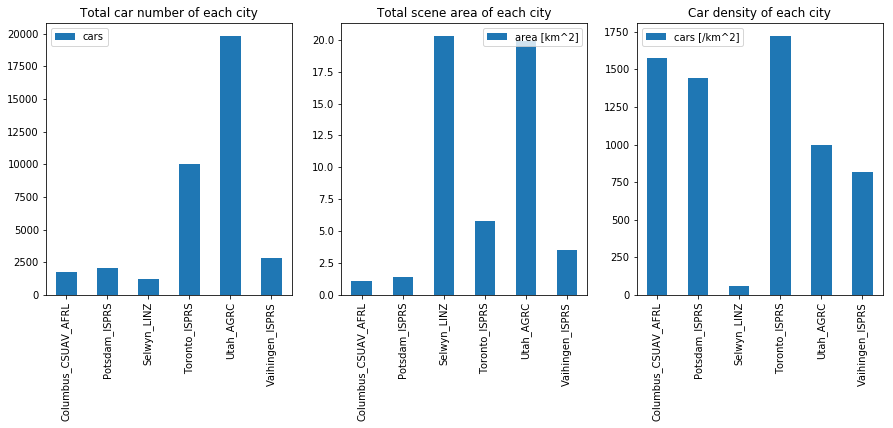

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5* 3, 5))
stats_df.plot(ax=axes[0], kind='bar', y=['cars'], title='Total car number of each city')
stats_df.plot(ax=axes[1], kind='bar', y=['area [km^2]'], title='Total scene area of each city')
stats_df.plot(ax=axes[2], kind='bar', y=['cars [/km^2]'], title='Car density of each city')